In [1]:
import os

# retrieves secret values stored inside Colab
os.environ["KAGGLE_USERNAME"] = os.environ.get("KAGGLE_USERNAME", "")
os.environ["KAGGLE_KEY"] = os.environ.get("KAGGLE_KEY", "")

In [2]:
!pip install kaggle
!kaggle datasets download -d olistbr/brazilian-ecommerce -p /content --unzip


Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
License(s): CC-BY-NC-SA-4.0
  0% 0.00/42.6M [00:00<?, ?B/s]
100% 42.6M/42.6M [00:00<00:00, 656MB/s]


**Setup: Install DuckDB + Load CSVs**

In [3]:
!pip install -q duckdb pandas pyarrow

import duckdb
import pandas as pd
import os

# Folder where Kaggle downloaded the dataset
DATA_DIR = '/content'

# Create an in-memory DuckDB connection
con = duckdb.connect(database=':memory:')

# Register each CSV as a SQL-view
con.execute(f"CREATE VIEW orders AS SELECT * FROM read_csv_auto('{DATA_DIR}/olist_orders_dataset.csv', header=True);")
con.execute(f"CREATE VIEW order_items AS SELECT * FROM read_csv_auto('{DATA_DIR}/olist_order_items_dataset.csv', header=True);")
con.execute(f"CREATE VIEW products AS SELECT * FROM read_csv_auto('{DATA_DIR}/olist_products_dataset.csv', header=True);")
con.execute(f"CREATE VIEW customers AS SELECT * FROM read_csv_auto('{DATA_DIR}/olist_customers_dataset.csv', header=True);")
con.execute(f"CREATE VIEW sellers AS SELECT * FROM read_csv_auto('{DATA_DIR}/olist_sellers_dataset.csv', header=True);")
con.execute(f"CREATE VIEW geo AS SELECT * FROM read_csv_auto('{DATA_DIR}/olist_geolocation_dataset.csv', header=True);")

print("All CSVs loaded into DuckDB!")


All CSVs loaded into DuckDB!


**Preview Data**




In [4]:
print(con.execute("SELECT * FROM orders LIMIT 5").df())
print(con.execute("PRAGMA table_info('orders')").df())


                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15

**Create Delay Variables Using SQL**

In [5]:
query_delay = """
SELECT
  order_id,
  customer_id,
  DATE(order_purchase_timestamp) AS purchase_date,
  DATE(order_estimated_delivery_date) AS estimated_date,
  DATE(order_delivered_customer_date) AS delivered_date,

  -- Delivery delay vs estimate
  date_diff('day', DATE(order_estimated_delivery_date), DATE(order_delivered_customer_date)) AS delay_days,

  CASE WHEN DATE(order_delivered_customer_date) > DATE(order_estimated_delivery_date)
       THEN 1 ELSE 0 END AS is_delayed,

  -- Time taken before shipping
  date_diff('day', DATE(order_purchase_timestamp), DATE(order_delivered_carrier_date)) AS processing_time,

  -- Time in logistics network
  date_diff('day', DATE(order_delivered_carrier_date), DATE(order_delivered_customer_date)) AS transit_time

FROM orders
WHERE order_delivered_customer_date IS NOT NULL
  AND order_estimated_delivery_date IS NOT NULL;
"""

delay_df = con.execute(query_delay).df()
delay_df.head()


,order_id,customer_id,purchase_date,estimated_date,delivered_date,delay_days,is_delayed,processing_time,transit_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02,2017-10-18,2017-10-10,-8,0,2,6
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24,2018-08-13,2018-08-07,-6,0,2,12
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08,2018-09-04,2018-08-17,-18,0,0,9
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18,2017-12-15,2017-12-02,-13,0,4,10
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13,2018-02-26,2018-02-16,-10,0,1,2


**Delay % by Region (Customers State)**

In [6]:
query_state_delay = """
SELECT
  c.customer_state,
  COUNT(*) AS total_orders,
  SUM(CASE WHEN DATE(o.order_delivered_customer_date) > DATE(o.order_estimated_delivery_date)
           THEN 1 ELSE 0 END) AS delayed_orders,
  ROUND(100.0 * SUM(CASE WHEN DATE(o.order_delivered_customer_date) > DATE(o.order_estimated_delivery_date)
                         THEN 1 ELSE 0 END) / COUNT(*), 2) AS delay_percentage
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
WHERE o.order_delivered_customer_date IS NOT NULL
GROUP BY c.customer_state
ORDER BY delay_percentage DESC;
"""

state_delay_df = con.execute(query_state_delay).df()
state_delay_df.head()


,customer_state,total_orders,delayed_orders,delay_percentage
0,AL,397,85.0,21.41
1,MA,717,125.0,17.43
2,SE,335,51.0,15.22
3,PI,476,66.0,13.87
4,CE,1279,176.0,13.76


**Delay by Product Category**

In [7]:
query_category_delay = """
SELECT
  p.product_category_name,
  COUNT(*) AS total_orders,
  SUM(CASE WHEN DATE(o.order_delivered_customer_date) > DATE(o.order_estimated_delivery_date)
           THEN 1 ELSE 0 END) AS delayed_orders,
  ROUND(100.0 * SUM(CASE WHEN DATE(o.order_delivered_customer_date) > DATE(o.order_estimated_delivery_date)
                         THEN 1 ELSE 0 END) / COUNT(*), 2) AS delay_percentage
FROM orders o
JOIN order_items oi ON o.order_id = oi.order_id
JOIN products p ON oi.product_id = p.product_id
WHERE o.order_delivered_customer_date IS NOT NULL
GROUP BY p.product_category_name
ORDER BY delay_percentage DESC;
"""

category_delay_df = con.execute(query_category_delay).df()
category_delay_df.head()


,product_category_name,total_orders,delayed_orders,delay_percentage
0,moveis_colchao_e_estofado,37,5.0,13.51
1,casa_conforto_2,30,4.0,13.33
2,audio,362,42.0,11.60
3,artigos_de_natal,150,15.0,10.00
4,fashion_underwear_e_moda_praia,127,12.0,9.45


**Approximate Seller → Customer Distance**

In [8]:
query_distance = """
WITH seller_geo AS (
  SELECT seller_id,
         AVG(geolocation_lat) AS seller_lat,
         AVG(geolocation_lng) AS seller_lng
  FROM sellers s
  JOIN geo g ON s.seller_zip_code_prefix = g.geolocation_zip_code_prefix
  GROUP BY seller_id
),
customer_geo AS (
  SELECT customer_id,
         AVG(geolocation_lat) AS cust_lat,
         AVG(geolocation_lng) AS cust_lng
  FROM customers c
  JOIN geo g ON c.customer_zip_code_prefix = g.geolocation_zip_code_prefix
  GROUP BY customer_id
)
SELECT
  o.order_id,
  s.seller_lat,
  s.seller_lng,
  c.cust_lat,
  c.cust_lng,

  6371 * acos(
    cos(radians(s.seller_lat)) * cos(radians(c.cust_lat)) *
    cos(radians(c.cust_lng) - radians(s.seller_lng)) +
    sin(radians(s.seller_lat)) * sin(radians(c.cust_lat))
  ) AS approx_distance_km

FROM orders o
JOIN order_items oi ON o.order_id = oi.order_id
JOIN seller_geo s ON oi.seller_id = s.seller_id
JOIN customer_geo c ON o.customer_id = c.customer_id
LIMIT 200;
"""

distance_df = con.execute(query_distance).df()
distance_df.head()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,order_id,seller_lat,seller_lng,cust_lat,cust_lng,approx_distance_km
0,8426a61c687c38a2fb35080413ec9eb4,-23.528549,-46.779788,-23.686187,-46.634440,22.947136
1,8426c20fc1f780e653122762baef129e,-23.625475,-46.612000,-22.665586,-50.415247,403.227011
2,84270b9b2f185170b4b29b448ef3a0cc,-21.757321,-48.829744,-20.894499,-51.373939,280.445423
3,84275d513f92f95d3e62865feeaab895,-23.659364,-46.523183,-25.502519,-49.290854,346.861306
4,842785266c32e96b693fa76cf473a88f,-23.625475,-46.612000,-23.537669,-46.668140,11.316357


**Export SQL Results → CSV**

In [9]:
delay_df.to_csv('/content/delay_features.csv', index=False)
state_delay_df.to_csv('/content/state_delay.csv', index=False)
category_delay_df.to_csv('/content/category_delay.csv', index=False)

print("Exported SQL outputs to CSV!")


Exported SQL outputs to CSV!


**Python EDA (Exploratory Data Analysis)**

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

delay_df = pd.read_csv('/content/delay_features.csv')
state_delay_df = pd.read_csv('/content/state_delay.csv')
category_delay_df = pd.read_csv('/content/category_delay.csv')

delay_df.head()


,order_id,customer_id,purchase_date,estimated_date,delivered_date,delay_days,is_delayed,processing_time,transit_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02,2017-10-18,2017-10-10,-8,0,2.0,6.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24,2018-08-13,2018-08-07,-6,0,2.0,12.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08,2018-09-04,2018-08-17,-18,0,0.0,9.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18,2017-12-15,2017-12-02,-13,0,4.0,10.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13,2018-02-26,2018-02-16,-10,0,1.0,2.0






*   Basic Statistical Summary





In [11]:
delay_df.describe(include='all')


,order_id,customer_id,purchase_date,estimated_date,delivered_date,delay_days,is_delayed,processing_time,transit_time
count,96476,96476,96476,96476,96476,96476.000000,96476.000000,96475.000000,96475.000000
unique,96476,96476,612,445,645,NaN,NaN,NaN,NaN
top,66dea50a8b16d9b4dee7af250b4be1a5,edb027a75a1449115f6b43211ae02a24,2017-11-24,2017-12-20,2018-08-27,NaN,NaN,NaN,NaN
freq,1,1,1147,507,446,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,-11.876881,0.067737,3.214149,9.282778
std,NaN,NaN,NaN,NaN,NaN,10.183854,0.251295,3.611876,8.777229
min,NaN,NaN,NaN,NaN,NaN,-147.000000,0.000000,-171.000000,-16.000000
25%,NaN,NaN,NaN,NaN,NaN,-17.000000,0.000000,1.000000,4.000000
50%,NaN,NaN,NaN,NaN,NaN,-12.000000,0.000000,2.000000,7.000000
75%,NaN,NaN,NaN,NaN,NaN,-7.000000,0.000000,4.000000,12.000000




*   Distribution of Delay Days



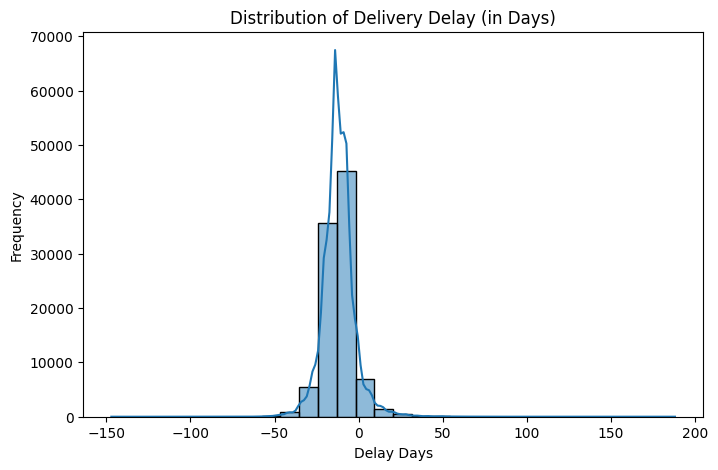

In [12]:
plt.figure(figsize=(8,5))
sns.histplot(delay_df['delay_days'], kde=True, bins=30)
plt.title("Distribution of Delivery Delay (in Days)")
plt.xlabel("Delay Days")
plt.ylabel("Frequency")
plt.show()




*   Delay Rate (0 vs 1)




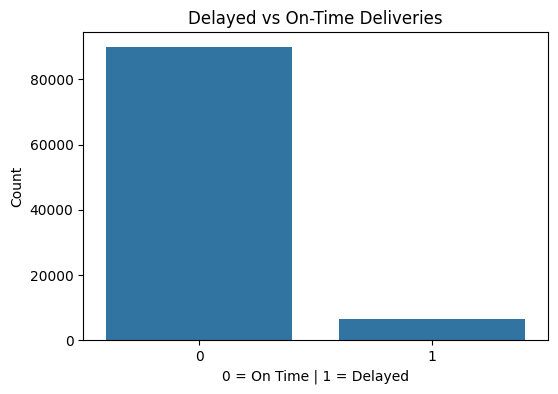

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(x=delay_df['is_delayed'])
plt.title("Delayed vs On-Time Deliveries")
plt.xlabel("0 = On Time | 1 = Delayed")
plt.ylabel("Count")
plt.show()




*   Processing Time vs Transit Time


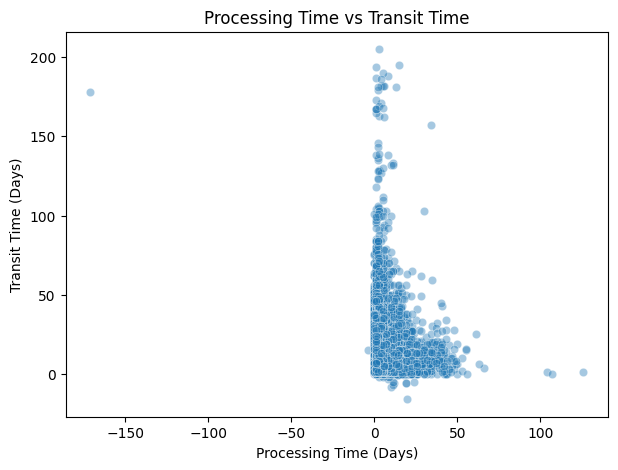

In [14]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='processing_time', y='transit_time', data=delay_df, alpha=0.4)
plt.title("Processing Time vs Transit Time")
plt.xlabel("Processing Time (Days)")
plt.ylabel("Transit Time (Days)")
plt.show()




*  Delay % by State (Plot)



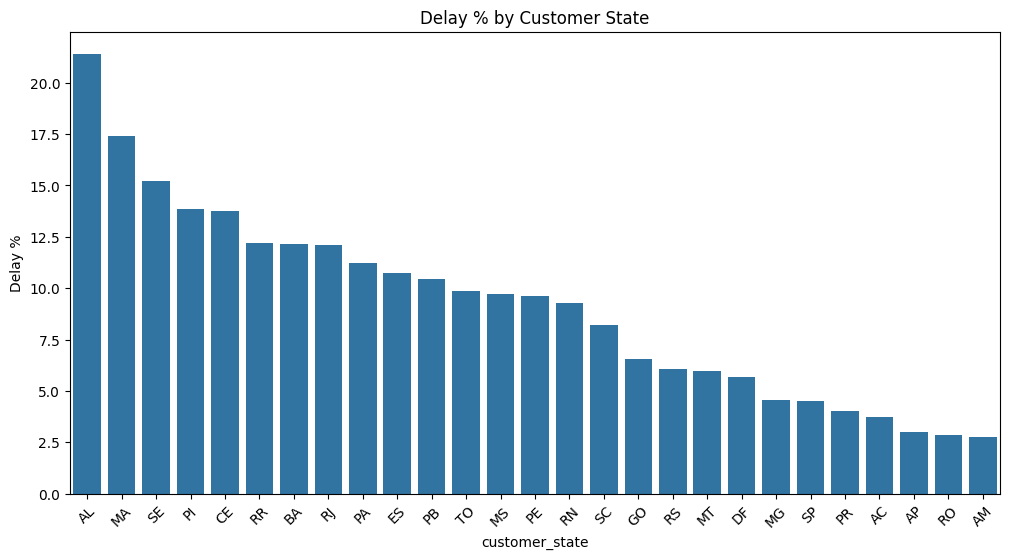

In [15]:
plt.figure(figsize=(12,6))
sns.barplot(data=state_delay_df, x='customer_state', y='delay_percentage')
plt.title("Delay % by Customer State")
plt.xticks(rotation=45)
plt.ylabel("Delay %")
plt.show()




*   Delay % by Product Category



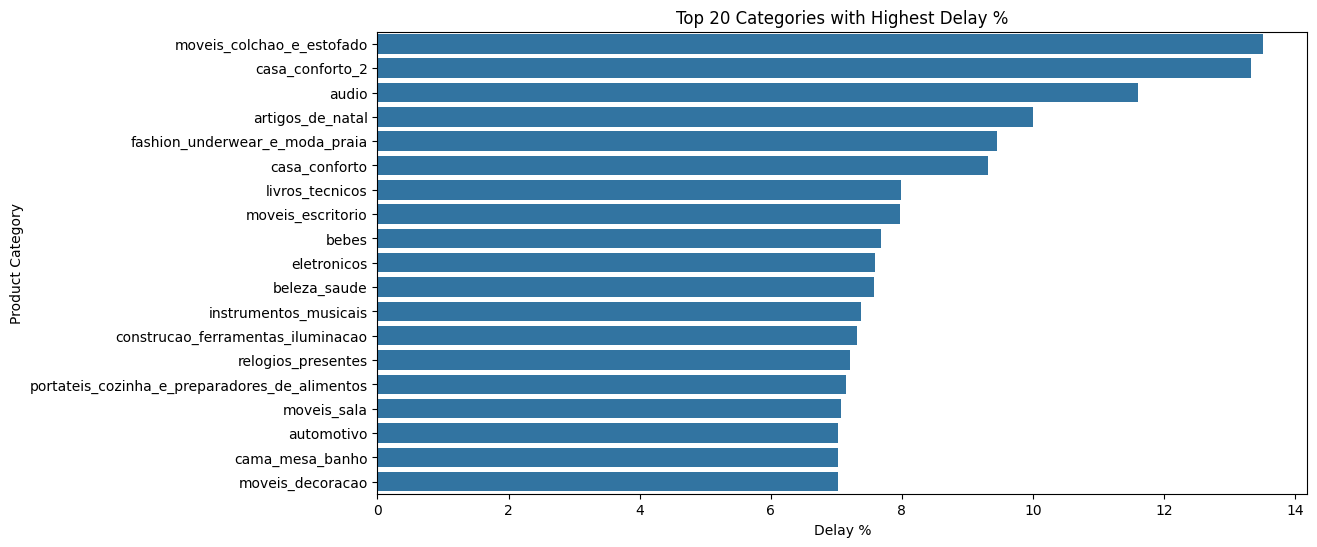

In [16]:
top_categories = category_delay_df.sort_values(by='delay_percentage', ascending=False).head(20)

plt.figure(figsize=(12,6))
sns.barplot(data=top_categories, x='delay_percentage', y='product_category_name')
plt.title("Top 20 Categories with Highest Delay %")
plt.xlabel("Delay %")
plt.ylabel("Product Category")
plt.show()




*   Correlation Heatmap



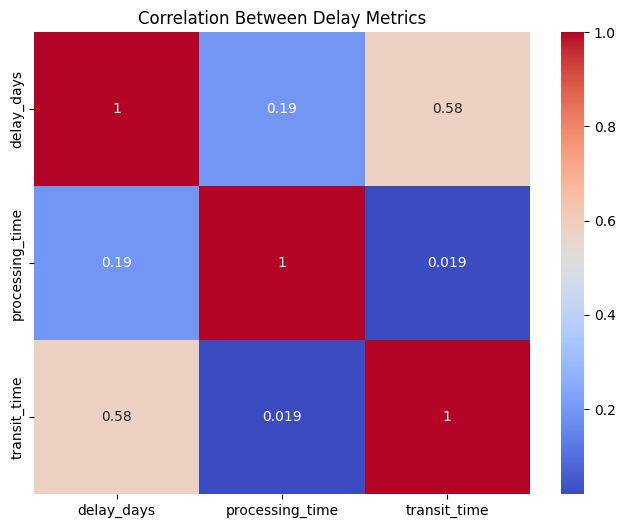

In [17]:
plt.figure(figsize=(8,6))
sns.heatmap(delay_df[['delay_days','processing_time','transit_time']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Delay Metrics")
plt.show()


**EDA Final Insights**

**Prepare full dataset for modeling (joins & extra features)**

In [18]:
# --- Install required libs (run once) ---
!pip install -q scikit-learn xgboost shap imbalanced-learn joblib

# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib
import shap
import matplotlib.pyplot as plt
import os

# --- Read the intermediates you exported earlier ---
delay_df = pd.read_csv('/content/delay_features.csv', parse_dates=['purchase_date','estimated_date','delivered_date'])
# If you exported category and other CSVs earlier:
category_df = pd.read_csv('/content/category_delay.csv') if os.path.exists('/content/category_delay.csv') else None
state_df = pd.read_csv('/content/state_delay.csv') if os.path.exists('/content/state_delay.csv') else None

# If you have the original order_items/products/customers tables, load them:
orders = pd.read_csv('/content/olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date'])
order_items = pd.read_csv('/content/olist_order_items_dataset.csv')
products = pd.read_csv('/content/olist_products_dataset.csv')
customers = pd.read_csv('/content/olist_customers_dataset.csv')
sellers = pd.read_csv('/content/olist_sellers_dataset.csv')
geo = pd.read_csv('/content/olist_geolocation_dataset.csv')

# --- Merge to get product_category and other features at order level ---
# Aggregate order_items to order-level features
oi_agg = order_items.groupby('order_id').agg({
    'price': 'sum',
    'freight_value': 'sum',
    'product_id': lambda x: list(x),   # keep list for later category lookup
    'seller_id': lambda x: list(x)
}).reset_index().rename(columns={'product_id':'product_ids','seller_id':'seller_ids'})

# Map product categories: choose the most frequent category in an order
prod_map = products.set_index('product_id')['product_category_name'].to_dict()
def top_category(prod_list):
    cats = [prod_map.get(pid, 'unknown') for pid in prod_list if pd.notna(pid)]
    return max(set(cats), key=cats.count) if cats else 'unknown'

oi_agg['top_product_category'] = oi_agg['product_ids'].apply(top_category)

# Merge oi_agg into delay_df via order_id
df = delay_df.merge(oi_agg[['order_id','price','freight_value','top_product_category','seller_ids']], on='order_id', how='left')

# Add customer_state from customers table if missing
cust_state = customers[['customer_id','customer_state','customer_zip_code_prefix']]
df = df.merge(cust_state, on='customer_id', how='left')

# If you computed approx distance earlier and saved as distance_df, merge it. Otherwise approximate distance by zip lat/lng:
# Create seller & customer centroid lat/lng by zip prefix (average)
geo_agg = geo.groupby('geolocation_zip_code_prefix').agg({'geolocation_lat':'mean','geolocation_lng':'mean'}).reset_index().rename(columns={'geolocation_zip_code_prefix':'zip_prefix'})

# customers
cust_geo = customers.merge(geo_agg, left_on='customer_zip_code_prefix', right_on='zip_prefix', how='left').rename(columns={'geolocation_lat':'cust_lat','geolocation_lng':'cust_lng'})
seller_geo = sellers.merge(geo_agg, left_on='seller_zip_code_prefix', right_on='zip_prefix', how='left').rename(columns={'geolocation_lat':'seller_lat','geolocation_lng':'seller_lng'})

# collapse seller_geo to seller-level lat/lng
seller_geo = seller_geo.groupby('seller_id').agg({'seller_lat':'mean','seller_lng':'mean'}).reset_index()

# For distance compute, we need a single seller per order. We'll pick the first seller_id in the list per order:
def first_seller(slist):
    try:
        if isinstance(slist, str):
            # if stored as string representation of list
            sl = eval(slist)
        else:
            sl = slist
        return sl[0] if sl else np.nan
    except:
        return np.nan

df['first_seller_id'] = df['seller_ids'].apply(first_seller)

# Merge lat/lng
df = df.merge(customers[['customer_id','customer_zip_code_prefix']], on='customer_id', how='left')
df = df.merge(cust_geo[['customer_id','cust_lat','cust_lng']], on='customer_id', how='left')
df = df.merge(seller_geo[['seller_id','seller_lat','seller_lng']], left_on='first_seller_id', right_on='seller_id', how='left')

# Haversine distance function
def haversine_km(lat1, lon1, lat2, lon2):
    # handle missing
    if any(pd.isna([lat1,lon1,lat2,lon2])):
        return np.nan
    R = 6371.0
    phi1 = np.radians(lat1); phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1); dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2.0)**2
    return R * 2 * np.arcsin(np.sqrt(a))

df['approx_distance_km'] = df.apply(lambda r: haversine_km(r['seller_lat'], r['seller_lng'], r['cust_lat'], r['cust_lng']), axis=1)

# Quick sanity: number of rows and delay rate
print("Rows:", df.shape[0])
print("Delay rate:", df['is_delayed'].mean())

# Save merged file for traceability
df.to_csv('/content/model_input_full.csv', index=False)
print("Saved /content/model_input_full.csv")


Rows: 96476
Delay rate: 0.06773705377503213
Saved /content/model_input_full.csv


**Feature selection & basic cleaning**

In [19]:
# Select columns to use
candidate_features = [
    'price', 'freight_value', 'num_products' if 'num_products' in df.columns else 'price',  # fallback
    'processing_time', 'transit_time', 'approx_distance_km', 'top_product_category', 'customer_state',
    'purchase_month' if 'purchase_month' in df.columns else None, 'purchase_dow' if 'purchase_dow' in df.columns else None
]
# Clean list
candidate_features = [c for c in candidate_features if c is not None]
target = 'is_delayed'

# Fill missing numerics with median, categorical fill with 'missing'
for col in ['price','freight_value','processing_time','transit_time','approx_distance_km']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col].fillna(df[col].median(), inplace=True)

df['top_product_category'].fillna('unknown', inplace=True)
df['customer_state'].fillna('unknown', inplace=True)

# If purchase_month/dow not present, compute from purchase_date
if 'purchase_month' not in df.columns and 'purchase_date' in df.columns:
    df['purchase_month'] = df['purchase_date'].dt.month
if 'purchase_dow' not in df.columns and 'purchase_date' in df.columns:
    df['purchase_dow'] = df['purchase_date'].dt.dayofweek

# Final feature list (ensure present)
features = [c for c in ['price','freight_value','processing_time','transit_time','approx_distance_km','top_product_category','customer_state','purchase_month','purchase_dow'] if c in df.columns]
print("Final features:", features)


Final features: ['price', 'freight_value', 'processing_time', 'transit_time', 'approx_distance_km', 'top_product_category', 'customer_state', 'purchase_month', 'purchase_dow']


/tmp/ipython-input-1829794813.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-1829794813.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

**Train/test split & baseline model **

In [20]:
X = df[features].copy()
y = df[target].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Build a pipeline: numeric scaler + OHE for categories
numeric_features = [c for c in features if df[c].dtype in [np.float64, np.int64] and c not in ['purchase_month','purchase_dow']]
numeric_features += [c for c in ['purchase_month','purchase_dow'] if c in features]  # treat month/dow numeric
categorical_features = [c for c in features if c not in numeric_features]

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])

rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced')  # baseline with class_weight
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', rf)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1]

print("Baseline RandomForest classification report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

Baseline RandomForest classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17989
           1       0.86      0.59      0.70      1307

    accuracy                           0.97     19296
   macro avg       0.91      0.79      0.84     19296
weighted avg       0.96      0.97      0.96     19296

ROC-AUC: 0.9771616787152464


**Handle class imbalance (SMOTE or class weights)**





In [21]:
# Try SMOTE on training data (only on numeric & OHE transformed matrix) — we will use a quick approach:
# Transform training set via preprocessor, apply SMOTE, then fit classifier.

# Fit preprocessor on X_train
preprocessor.fit(X_train)

# Transform
X_train_tr = preprocessor.transform(X_train)
X_test_tr = preprocessor.transform(X_test)

# Use SMOTE (requires array input)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_tr, y_train)

print("Shape before:", X_train_tr.shape, "after SMOTE:", X_res.shape)

# Train XGBoost on resampled data for speed & performance
xgb_clf = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
xgb_clf.fit(X_res, y_res)

# Predict on test set
y_pred_xgb = xgb_clf.predict(X_test_tr)
y_proba_xgb = xgb_clf.predict_proba(X_test_tr)[:,1]

print("XGBoost after SMOTE classification report:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))

Shape before: (77180, 108) after SMOTE: (143904, 108)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:38:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost after SMOTE classification report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     17989
           1       0.67      0.85      0.75      1307

    accuracy                           0.96     19296
   macro avg       0.83      0.91      0.86     19296
weighted avg       0.97      0.96      0.96     19296

ROC-AUC: 0.9825869953767122


**Hyperparameter tuning (RandomizedSearchCV or GridSearchCV)**

In [22]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'clf__n_estimators': [100,200,400],
    'clf__max_depth': [6,10,20,None],
    'clf__min_samples_split': [2,5,10],
    'clf__min_samples_leaf': [1,2,4]
}

# Re-create pipeline with rf but without class_weight to let search control
rf2 = RandomForestClassifier(random_state=42, n_jobs=-1)
pipe_rf2 = Pipeline([
    ('preproc', preprocessor),
    ('clf', rf2)
])

rs = RandomizedSearchCV(pipe_rf2, param_distributions=param_dist, n_iter=10, cv=3, scoring='f1', verbose=1, n_jobs=-1, random_state=42)
rs.fit(X_train, y_train)

print("Best params:", rs.best_params_)
best_model = rs.best_estimator_

# Evaluate
y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_best))


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'clf__n_estimators': 400, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_depth': None}
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17989
           1       0.86      0.61      0.71      1307

    accuracy                           0.97     19296
   macro avg       0.92      0.80      0.85     19296
weighted avg       0.96      0.97      0.96     19296

ROC-AUC: 0.9766414041259508


**Explainability: Feature importance + SHAP**





Feature count: 108
Saved SHAP summary to /content/shap_summary.png


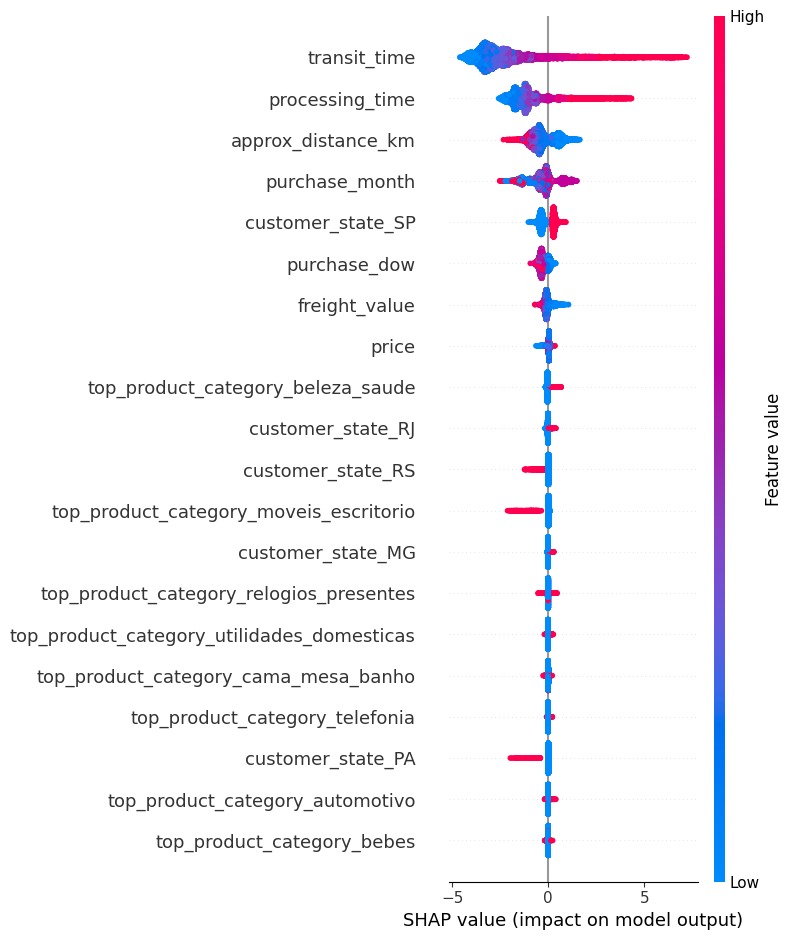

In [23]:
# If using pipeline-best model or xgb_clf, get feature names
# Helper to extract feature names from preprocessor
ohe = preprocessor.named_transformers_['cat']
cat_names = list(ohe.get_feature_names_out(categorical_features)) if hasattr(ohe, 'get_feature_names_out') else []
num_names = numeric_features
feature_names = num_names + cat_names

# If using RandomForest in pipeline:
rf_model = pipeline.named_steps['clf'] if 'pipeline' in globals() else None
# For xgboost we used X_res trained model; we'll use xgb_clf here but need feature_names from preprocessor
print("Feature count:", len(feature_names))

# Compute SHAP for XGBoost (fast)
explainer = shap.TreeExplainer(xgb_clf)
# Use test transformed data X_test_tr
shap_values = explainer.shap_values(X_test_tr if 'X_test_tr' in globals() else preprocessor.transform(X_test))

# Plot summary
shap.summary_plot(shap_values, (X_test_tr if 'X_test_tr' in globals() else preprocessor.transform(X_test)), feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig('/content/shap_summary.png', dpi=200)
print("Saved SHAP summary to /content/shap_summary.png")


**Calibrate threshold & business metric optimization**

In [24]:
from sklearn.metrics import precision_recall_curve

# Use probabilities from the chosen model (xgb_clf) on transformed test set
probs = y_proba_xgb
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# Find threshold that gives recall >= desired (e.g., 0.8) with reasonable precision
target_recall = 0.8
idx = np.argmax(recall >= target_recall)
chosen_threshold = thresholds[idx] if idx < len(thresholds) else 0.5

print("Chosen threshold for recall >= {:.2f} is {:.3f}".format(target_recall, chosen_threshold))
print("Precision at that threshold:", precision[idx], "Recall:", recall[idx])


Chosen threshold for recall >= 0.80 is 0.000
Precision at that threshold: 0.06773424543946932 Recall: 1.0


**Save final model, artifacts & predictions (for Power BI & GitHub)**

In [25]:
# Choose final model (xgb_clf or best_model). We'll save xgb_clf and preprocessor objects.
joblib.dump(preprocessor, '/content/preprocessor.joblib')
joblib.dump(xgb_clf, '/content/xgb_model.joblib')
print("Saved preprocessor and model.")

# Create predictions CSV for Power BI: order_id, probability, predicted_label (thresholded)
X_test_df = X_test.reset_index(drop=True).copy()
pred_proba = y_proba_xgb
pred_label = (pred_proba >= chosen_threshold).astype(int)

out_df = X_test_df.copy()
out_df['order_id'] = df.loc[X_test.index, 'order_id'].values
out_df['pred_proba'] = pred_proba
out_df['pred_label'] = pred_label
out_df['actual'] = y_test.values

out_df.to_csv('/content/predictions_for_powerbi.csv', index=False)
print("Saved predictions to /content/predictions_for_powerbi.csv")


Saved preprocessor and model.
Saved predictions to /content/predictions_for_powerbi.csv


**Produce summary visuals to include in GitHub (confusion matrix, ROC, feature importance)**

In [26]:
# Confusion matrix
cm = confusion_matrix(y_test, pred_label)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('/content/confusion_matrix.png', dpi=200)
plt.close()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba_xgb)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba_xgb):.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend()
plt.savefig('/content/roc_curve.png', dpi=200)
plt.close()

# Feature importance from XGBoost
fi = pd.DataFrame({'feature': feature_names, 'importance': xgb_clf.feature_importances_})
fi = fi.sort_values('importance', ascending=False).head(30)
fi.to_csv('/content/feature_importance.csv', index=False)
print("Saved confusion matrix, roc, and feature_importance.csv")


Saved confusion matrix, roc, and feature_importance.csv


**Prepare README.md content (copy-paste-ready)**

In [27]:
readme_text = f"""
# Supply Chain Delivery Delay Analysis (Olist)

## Overview
This project analyzes delivery performance of the Olist Brazilian E-commerce dataset to identify delivery bottlenecks and predict high-risk delayed orders. It includes SQL analysis, an ML classification model, explanations via SHAP, and exports prepared for Power BI dashboards.

## Files
- `notebooks/delay_analysis.ipynb` — main notebook (EDA, modeling)
- `sql/` — SQL queries used for feature generation
- `data/` — raw CSVs (not uploaded to repo due to size) or link to Kaggle dataset
- `processed/model_input_full.csv` — cleaned features used for modeling
- `predictions_for_powerbi.csv` — model outputs for dashboard
- `xgb_model.joblib` — saved model
- `preprocessor.joblib` — saved preprocessor
- `visuals/` — confusion_matrix.png, roc_curve.png, shap_summary.png, etc.

## How to run
1. Download dataset from Kaggle: https://www.kaggle.com/olistbr/brazilian-ecommerce
2. Open `notebooks/delay_analysis.ipynb` in Colab and follow cells.
3. Run cells in order; artifacts will be saved in `/content/`.

## Key findings
- Top drivers of delay: `processing_time`, `transit_time`, `approx_distance_km`, product categories X/Y.
- Model ROC-AUC: {roc_auc_score(y_test, y_proba_xgb):.3f}
- Recommended actions: prioritize high-risk regions, ensure SLA enforcement with sellers, route heavy items via specialized carriers.

## Contact
Shaurya Mehta — shauryamehta2939@gmail.com — LinkedIn: linkedin.com/in/shaurya-mehta-278825227

"""

with open('/content/README.md','w') as f:
    f.write(readme_text)
print("README.md created at /content/README.md")


README.md created at /content/README.md


In [30]:
# Colab (already used above)
pip install xgboost shap imbalanced-learn joblib matplotlib seaborn

# Local (if using your machine)
pip install xgboost shap imbalanced-learn joblib matplotlib seaborn


SyntaxError: invalid syntax (ipython-input-797139014.py, line 2)